In [3]:
import anndata
import anndata as ad
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import os
import numpy as np
import pandas as pd
import os
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import sparse
import matplotlib.pyplot as plt

In [4]:
sc.settings.verbosity=0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.n_jobs=4
sc.settings.set_figure_params(dpi=300, facecolor="white", frameon=False, figsize=(8,8))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline


In [5]:

sc.settings.figdir = "fig7"


# Load all cells

In [6]:
pandas2ri.activate()

seurat = importr('Seurat')
matrix = importr('Matrix')

file_path = os.path.expanduser("/lustre/scratch126/cellgen/team298/ls34/Mouse_SS_Fibro.RDS")

# Define the R function to read a Seurat object from an RDS file
r('''
    library(Seurat)
    read_seurat_obj <- function(file_path) {
        readRDS(file_path)
    }
''')

seurat_obj = ro.r['read_seurat_obj'](file_path)

num_cells = ro.r('function(x) dim(x)[2]')(seurat_obj)[0]
num_genes = ro.r('function(x) dim(x)[1]')(seurat_obj)[0]
print(f"The dataset contains {num_cells} cells and {num_genes} genes.")

r('''
    library(Seurat)
    library(Matrix)
    get_sparse_matrix <- function(x) {
        counts <- GetAssayData(x, slot = "counts")
        sparse_counts <- as(counts, "CsparseMatrix")
        return(sparse_counts)
    }
''')

exprs = ro.r('get_sparse_matrix')(seurat_obj)
meta_data = np.array(ro.r('function(x) as.data.frame(x@meta.data)')(seurat_obj))
meta_data_colnames = list(ro.r('function(x) colnames(x@meta.data)')(seurat_obj))
gene_names = np.array(ro.r('function(x) rownames(GetAssayData(x, slot = "counts"))')(seurat_obj))

exprs_sparse = sparse.csc_matrix((exprs.do_slot("x"), exprs.do_slot("i"), exprs.do_slot("p")), shape=exprs.do_slot("Dim"))

meta_data_df = pd.DataFrame(meta_data.T, columns=meta_data_colnames)  # Transpose the metadata

adata = ad.AnnData(X=exprs_sparse.T, obs=meta_data_df, var=pd.DataFrame(index=gene_names))
adata


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



The dataset contains 120583 cells and 21087 genes.


/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 120583 × 21087
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cluster', 'ClustName', 'Tissue'

# Normalise

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [8]:
adata_skin = adata[adata.obs["Tissue"]=="Skin"]

In [9]:
desired_order = [ 'Pi16',
                  'Col15a1',
                  'Comp',
               
 'Cxcl12',
                   'Ccl19',


 'Coch',
                  'Bmp4',
 'Hhip',
 'Fbln1',
 'Npnt',

]
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=desired_order, ordered=True)
adata.obs['ClustName2'] = adata.obs['ClustName'].astype(cat_type)
adata_skin.obs['ClustName2'] = adata_skin.obs['ClustName'].astype(cat_type)


/tmp/ipykernel_16525/4154255040.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_skin.obs['ClustName2'] = adata_skin.obs['ClustName'].astype(cat_type)


In [10]:
import pickle
pickle_file_path = '/nfs/team298/ls34/fb_dict.pkl'

# Open the pickle file and load the dictionary
with open(pickle_file_path, 'rb') as file:
    reynolds_short_final = pickle.load(file)
reynolds_short_final["F3"]


['CCL19',
 'CD74',
 'CH25H',
 'TNFSF13B',
 'IL33',
 'IRF8',
 'IL15',
 'VCAM1',
 'HLA-DRA',
 'HLA-DRB1']

In [11]:
#adata_hum = sc.read_h5ad('/nfs/team298/ls34/disease_atlas/data2/adata_fbspericytesnonlesional_SCVI_3526_new_neighbor50_ANNOTATED_umap30_leiden_paga3_FINALcoreonly.h5ad')
adata_hum = sc.read_h5ad(\
    '/nfs/team298/ls34/disease_atlas/final_fb_adatas/adata_fbspericytesnonlesional_SCVI_3526_new_neighbor50_ANNOTATED_umap30_leiden_paga3_FINALcoreonly.h5ad.v3')
                         
                         #'/nfs/team298/ls34/disease_atlas/data2/adata_fbspericytesnonlesional_SCVI_3526_new_neighbor50_ANNOTATED_umap30_leiden_paga3_FINALcoreonly.h5ad')

/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(

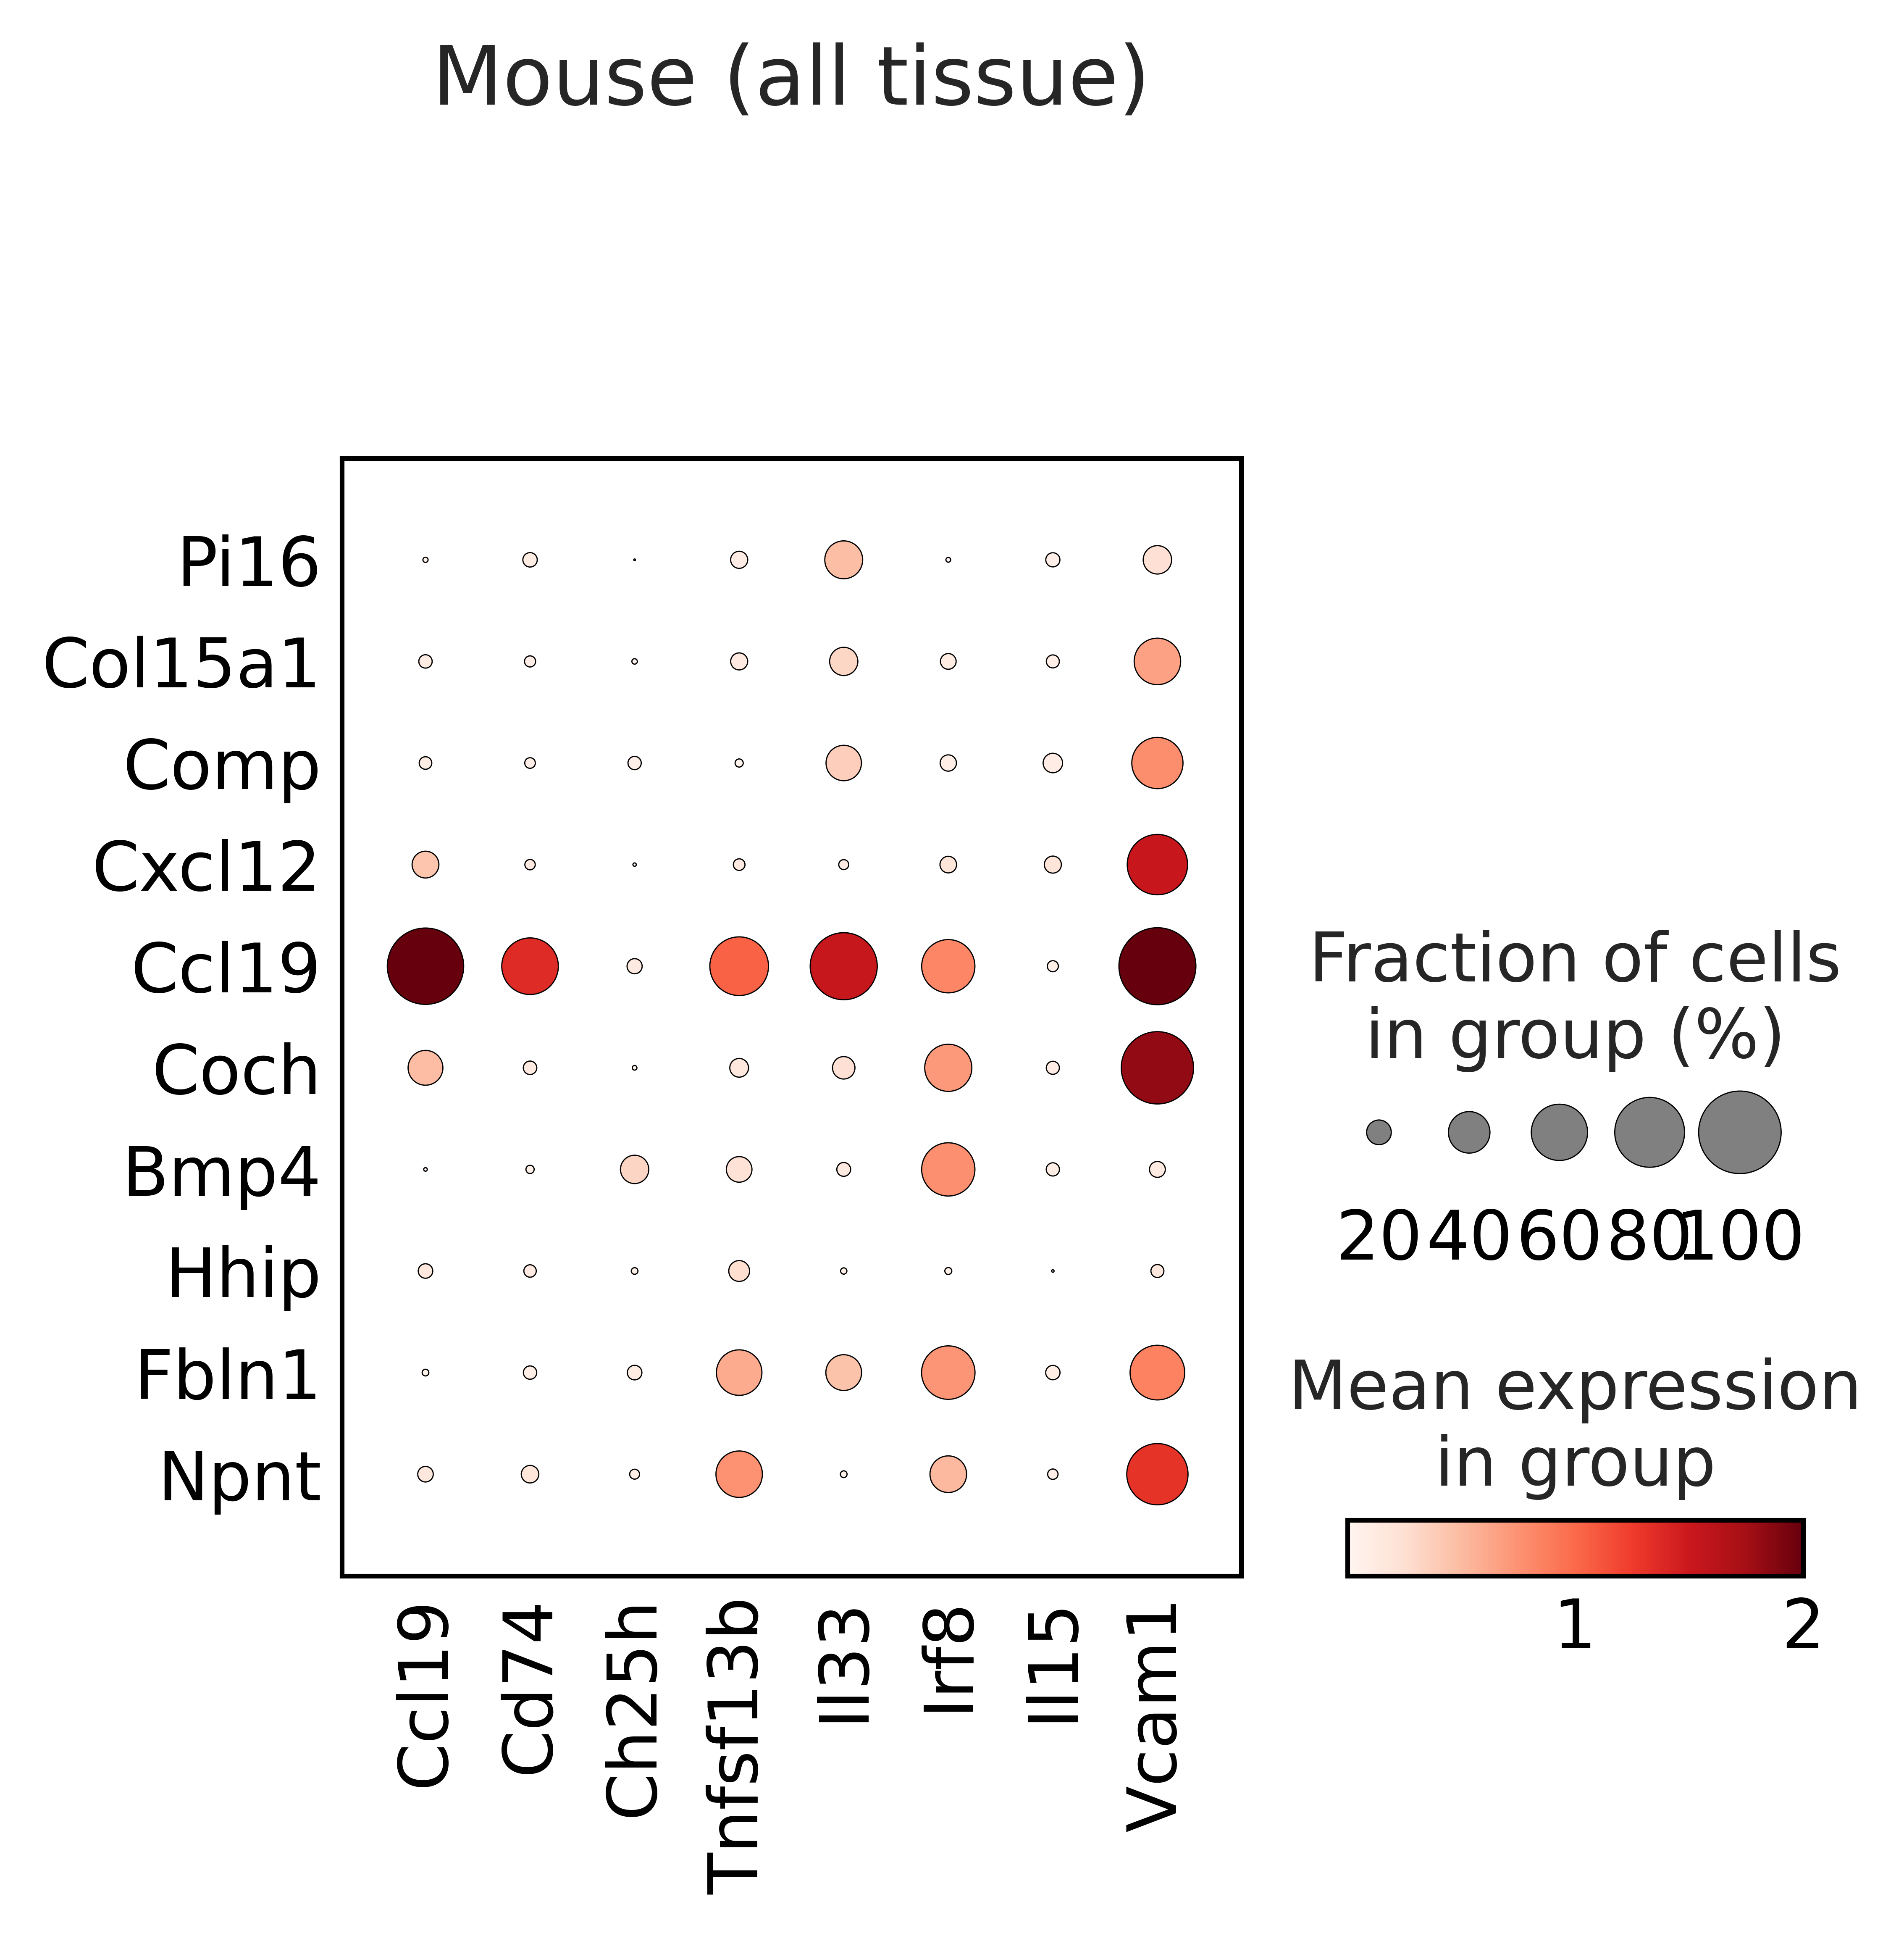

In [27]:
flattened_list_o=['CCL19',
 'CD74',
 'CH25H',
 'TNFSF13B',
 'IL33',
 'IRF8',
 'IL15',
 'VCAM1',
 'HLA-DRA',
 'HLA-DRB1'] 

# = [gene for sublist in reynolds_short3.values() for gene in sublist]
flattened_list = [s.capitalize() for s in flattened_list_o]
flattened_list = [x for x in flattened_list if x in adata.var_names]
flattened_list
sc.settings.set_figure_params(dpi=500, facecolor="white", frameon=False, figsize=(7,7))

sc.pl.dotplot(
    adata,
    flattened_list,
    groupby="ClustName2",
    #standard_scale="var",
    vmax=2,
    dendrogram=False,
    title="Mouse (all tissue)",
    save="mouse_homologousgenes.pdf"
) 
 
# sc.pl.dotplot(
#     adata_skin,
#     flattened_list,
#     groupby="ClustName2",
#     vmax=2,
# #    standard_scale="var",
#     dendrogram=False,
#     title="Mouse (skin)"
# ) 
# adata_hum

# sc.pl.dotplot(
#     adata_hum,
#     flattened_list_o,
#     groupby="corefb_names2",
#     vmax=2,
# #    standard_scale="var",
#     dendrogram=False,
#     title="Human (skin)"
# ) 
#sc.settings.set_figure_params(dpi=50, facecolor="white", frameon=False, figsize=(7,7))


# Mouse atlas

In [28]:
desired_order = [ 'Pi16',
                  'Col15a1',
                  'Comp',
               
 'Cxcl12',
                   'Ccl19',


 'Coch',
                  'Bmp4',
 'Hhip',
 'Fbln1',
 'Npnt',

]
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=desired_order, ordered=True)
adata.obs['ClustName2'] = adata.obs['ClustName'].astype(cat_type)
adata_skin.obs['ClustName2'] = adata_skin.obs['ClustName'].astype(cat_type)
 


/tmp/ipykernel_16525/3320545723.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_skin.obs['ClustName2'] = adata_skin.obs['ClustName'].astype(cat_type)


In [29]:
# import pandas as pd
# import matplotlib.pyplot as plt

# total_cells_per_tissue = adata.obs['Tissue'].value_counts()
# ccl19_cells_per_tissue = adata.obs[adata.obs['ClustName'] == 'Ccl19']['Tissue'].value_counts()

# proportion_ccl19 = ccl19_cells_per_tissue / total_cells_per_tissue

# proportion_ccl19 = proportion_ccl19.sort_index()

# plt.figure(figsize=(6, 6))  # Adjust the figsize for a narrower plot
# ax = proportion_ccl19.plot(kind='bar', color='#e60000')

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.xticks(rotation=90, fontsize=12)
# plt.ylabel("Proportion Ccl19+ (Mouse)", fontsize=20)
# plt.xlabel("", fontsize=20)

# plt.yticks(fontsize=12)
# plt.tight_layout()


# plt.show()

In [30]:
adata_skin = adata[adata.obs["Tissue"]=="Skin"]

In [31]:
adata_colon = adata[adata.obs["Tissue"]=="Liver"]
adata_LN = adata[adata.obs["Tissue"]=="Lymph Node"]

adata_lung = adata[adata.obs["Tissue"]=="Lung"]


In [32]:
mapping_dict = {
    "F2: Universal": "Pi16",
    "F2/3: Stroma_PPARG+": "Cxcl12",
    "F3: FRC-like": "Ccl19",
    "F1: Secretory": "Comp",
    "F4: TNN+COCH+": "Coch",
    "F4: DP_HHIP+": "Hhip"
}

adata_hum.obs["ClustName"] = adata_hum.obs["corefb_names"].map(mapping_dict)

adata_hum.obs["ClustName"].fillna("F4 DPEP1 + F5", inplace=True)
adata_hum.obs["ClustName2"] = adata_hum.obs["ClustName"]

/tmp/ipykernel_16525/1986748098.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata_hum.obs["ClustName"].fillna("F4 DPEP1 + F5", inplace=True)


In [33]:
adata_skin_proportions = adata_skin.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)
adata_lung_proportions = adata_lung.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)

adata_proportions = adata.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)

adata_hum_proportions = adata_hum.obs['ClustName2'].value_counts(normalize=True).sort_values(ascending=False)

all_categories = sorted(set(adata_skin_proportions.index).union(adata_proportions.index).union(adata_hum_proportions.index))

adata_skin_proportions = adata_skin_proportions[~adata_skin_proportions.index.duplicated()]
adata_proportions = adata_proportions[~adata_proportions.index.duplicated()]
adata_hum_proportions = adata_hum_proportions[~adata_hum_proportions.index.duplicated()]
adata_lung_proportions = adata_hum_proportions[~adata_hum_proportions.index.duplicated()]


adata_skin_proportions = adata_skin_proportions.reindex(all_categories, fill_value=0)
adata_proportions = adata_proportions.reindex(all_categories, fill_value=0)
adata_hum_proportions = adata_hum_proportions.reindex(all_categories, fill_value=0)
adata_lung_proportions = adata_hum_proportions.reindex(all_categories, fill_value=0)

df_skin = pd.DataFrame({'ClustName': adata_skin_proportions.index, 'Proportion': adata_skin_proportions.values, 'Dataset': 'Skin only (mouse)'})
df_adata = pd.DataFrame({'ClustName': adata_proportions.index, 'Proportion': adata_proportions.values, 'Dataset': 'All tissues (mouse)'})
df_hum = pd.DataFrame({'ClustName': adata_hum_proportions.index, 'Proportion': adata_hum_proportions.values, 'Dataset': 'Skin only (human)'})
df_lung = pd.DataFrame({'ClustName': adata_hum_proportions.index, 'Proportion': adata_lung_proportions.values, 'Dataset': 'Lung only (human)'})


df_combined = pd.concat([df_adata, df_skin, df_hum])

df_combined['ClustName'] = df_combined['ClustName'].apply(lambda x: x if x == 'Ccl19' else 'Other')

df_grouped = df_combined.groupby(['ClustName', 'Dataset']).agg({'Proportion': 'sum'}).reset_index()

df_grouped


,ClustName,Dataset,Proportion
0,Ccl19,All tissues (mouse),0.125018
1,Ccl19,Skin only (human),0.120037
2,Ccl19,Skin only (mouse),0.001338
3,Other,All tissues (mouse),0.874982
4,Other,Skin only (human),0.879963
5,Other,Skin only (mouse),0.998662


In [34]:
plt.style.use('seaborn-white')

adata_skin_proportions = adata_skin.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)
adata_colon_proportions = adata_colon.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)
adata_LN_proportions = adata_LN.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)

adata_proportions = adata.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)

df_skin = pd.DataFrame({'ClustName': adata_skin_proportions.index, 'Proportion': adata_skin_proportions.values, 'Dataset': 'Skin only (mouse)'})
df_colon = pd.DataFrame({'ClustName': adata_colon_proportions.index, 'Proportion': adata_colon_proportions.values, 'Dataset': 'Liver only (mouse)'})
df_LN = pd.DataFrame({'ClustName': adata_LN_proportions.index, 'Proportion': adata_LN_proportions.values, 'Dataset': 'LN only (mouse)'})
df_adata = pd.DataFrame({'ClustName': adata_lung_proportions.index, 'Proportion': adata_lung_proportions.values, 'Dataset': 'Lung only (mouse)'})
df_hum = pd.DataFrame({'ClustName': adata_hum_proportions.index, 'Proportion': adata_hum_proportions.values, 'Dataset': 'Skin only (human)'})


df_combined = pd.concat([ df_adata, df_LN, df_colon, df_skin,df_hum])

df_grouped = df_combined.groupby(['ClustName', 'Dataset']).agg({'Proportion': 'sum'}).reset_index()
df_grouped

/tmp/ipykernel_16525/2527470623.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


,ClustName,Dataset,Proportion
0,Bmp4,LN only (mouse),0.000377
1,Bmp4,Liver only (mouse),0.009981
2,Bmp4,Lung only (mouse),0.000000
3,Bmp4,Skin only (human),0.000000
4,Bmp4,Skin only (mouse),0.002230
5,Ccl19,LN only (mouse),0.851113
6,Ccl19,Liver only (mouse),0.034934
7,Ccl19,Lung only (mouse),0.120037
8,Ccl19,Skin only (human),0.120037
9,Ccl19,Skin only (mouse),0.001338


In [35]:
# import matplotlib.pyplot as plt

# sc.settings.set_figure_params(dpi=500, facecolor="white", frameon=False, figsize=(7,7))


# df_grouped['Proportion'] = df_grouped['Proportion'].round(4)
# df_pivot = df_grouped.pivot(index='Dataset', columns='ClustName', values='Proportion').fillna(0)
# order = [ 'LN only (mouse)',"Lung only (mouse)",   'Liver only (mouse)',   "Skin only (mouse)", "Skin only (human)"]
# df_pivot = df_pivot.loc[order]

# df_pivot = df_pivot[['Ccl19']]
# color = '#e60000'  # Stronger red

# ax = df_pivot.plot(kind='bar', stacked=True, color=color, figsize=(4, 4))

# ax.set_xticklabels(ax.get_xticklabels(), fontsize=30, rotation=90)  # Make xticks font size bigger
# ax.spines['top'].set_visible(False)  # Remove the top border
# ax.spines['right'].set_visible(False)  # Remove the right border
# ax.set_xlabel('')  # Remove the xlabel
# ax.set_ylabel('Proportion', fontsize=30)  # Make ylabel font size bigger
# ax.set_title('')  # Remove the title
# ax.set_ylim(0, 0.85)  # Set ymax to 0.2

# ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=30)  # Set yticks to 2 decimal places

# ax.get_legend().remove()

# plt.show()
 

In [36]:
# Ensure consistent style
plt.style.use('seaborn-white')

# Calculate proportions for adata_skin
adata_skin_proportions = adata_skin.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)
adata_colon_proportions = adata_colon.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)
adata_LN_proportions = adata_LN.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)

# Calculate proportions for adata
adata_proportions = adata.obs['ClustName'].value_counts(normalize=True).sort_values(ascending=False)

# Create a DataFrame for plotting
df_skin = pd.DataFrame({'ClustName': adata_skin_proportions.index, 'Proportion': adata_skin_proportions.values, 'Dataset': 'Skin only (mouse)'})
df_colon = pd.DataFrame({'ClustName': adata_colon_proportions.index, 'Proportion': adata_colon_proportions.values, 'Dataset': 'Liver only (mouse)'})
df_LN = pd.DataFrame({'ClustName': adata_LN_proportions.index, 'Proportion': adata_LN_proportions.values, 'Dataset': 'LN only (mouse)'})
df_lung = pd.DataFrame({'ClustName': adata_lung_proportions.index, 'Proportion': adata_lung_proportions.values, 'Dataset': 'Lung only (mouse)'})
df_hum = pd.DataFrame({'ClustName': adata_hum_proportions.index, 'Proportion': adata_hum_proportions.values, 'Dataset': 'Skin only (human)'})


df_combined = pd.concat([  df_LN, df_colon, df_skin,df_hum, df_lung])

# Now we need to group by the recoded ClustName and Dataset, summing up the Proportions
df_grouped = df_combined.groupby(['ClustName', 'Dataset']).agg({'Proportion': 'sum'}).reset_index()

# Display the resulting DataFrame
df_grouped

/tmp/ipykernel_16525/840873621.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


,ClustName,Dataset,Proportion
0,Bmp4,LN only (mouse),0.000377
1,Bmp4,Liver only (mouse),0.009981
2,Bmp4,Lung only (mouse),0.000000
3,Bmp4,Skin only (human),0.000000
4,Bmp4,Skin only (mouse),0.002230
5,Ccl19,LN only (mouse),0.851113
6,Ccl19,Liver only (mouse),0.034934
7,Ccl19,Lung only (mouse),0.120037
8,Ccl19,Skin only (human),0.120037
9,Ccl19,Skin only (mouse),0.001338


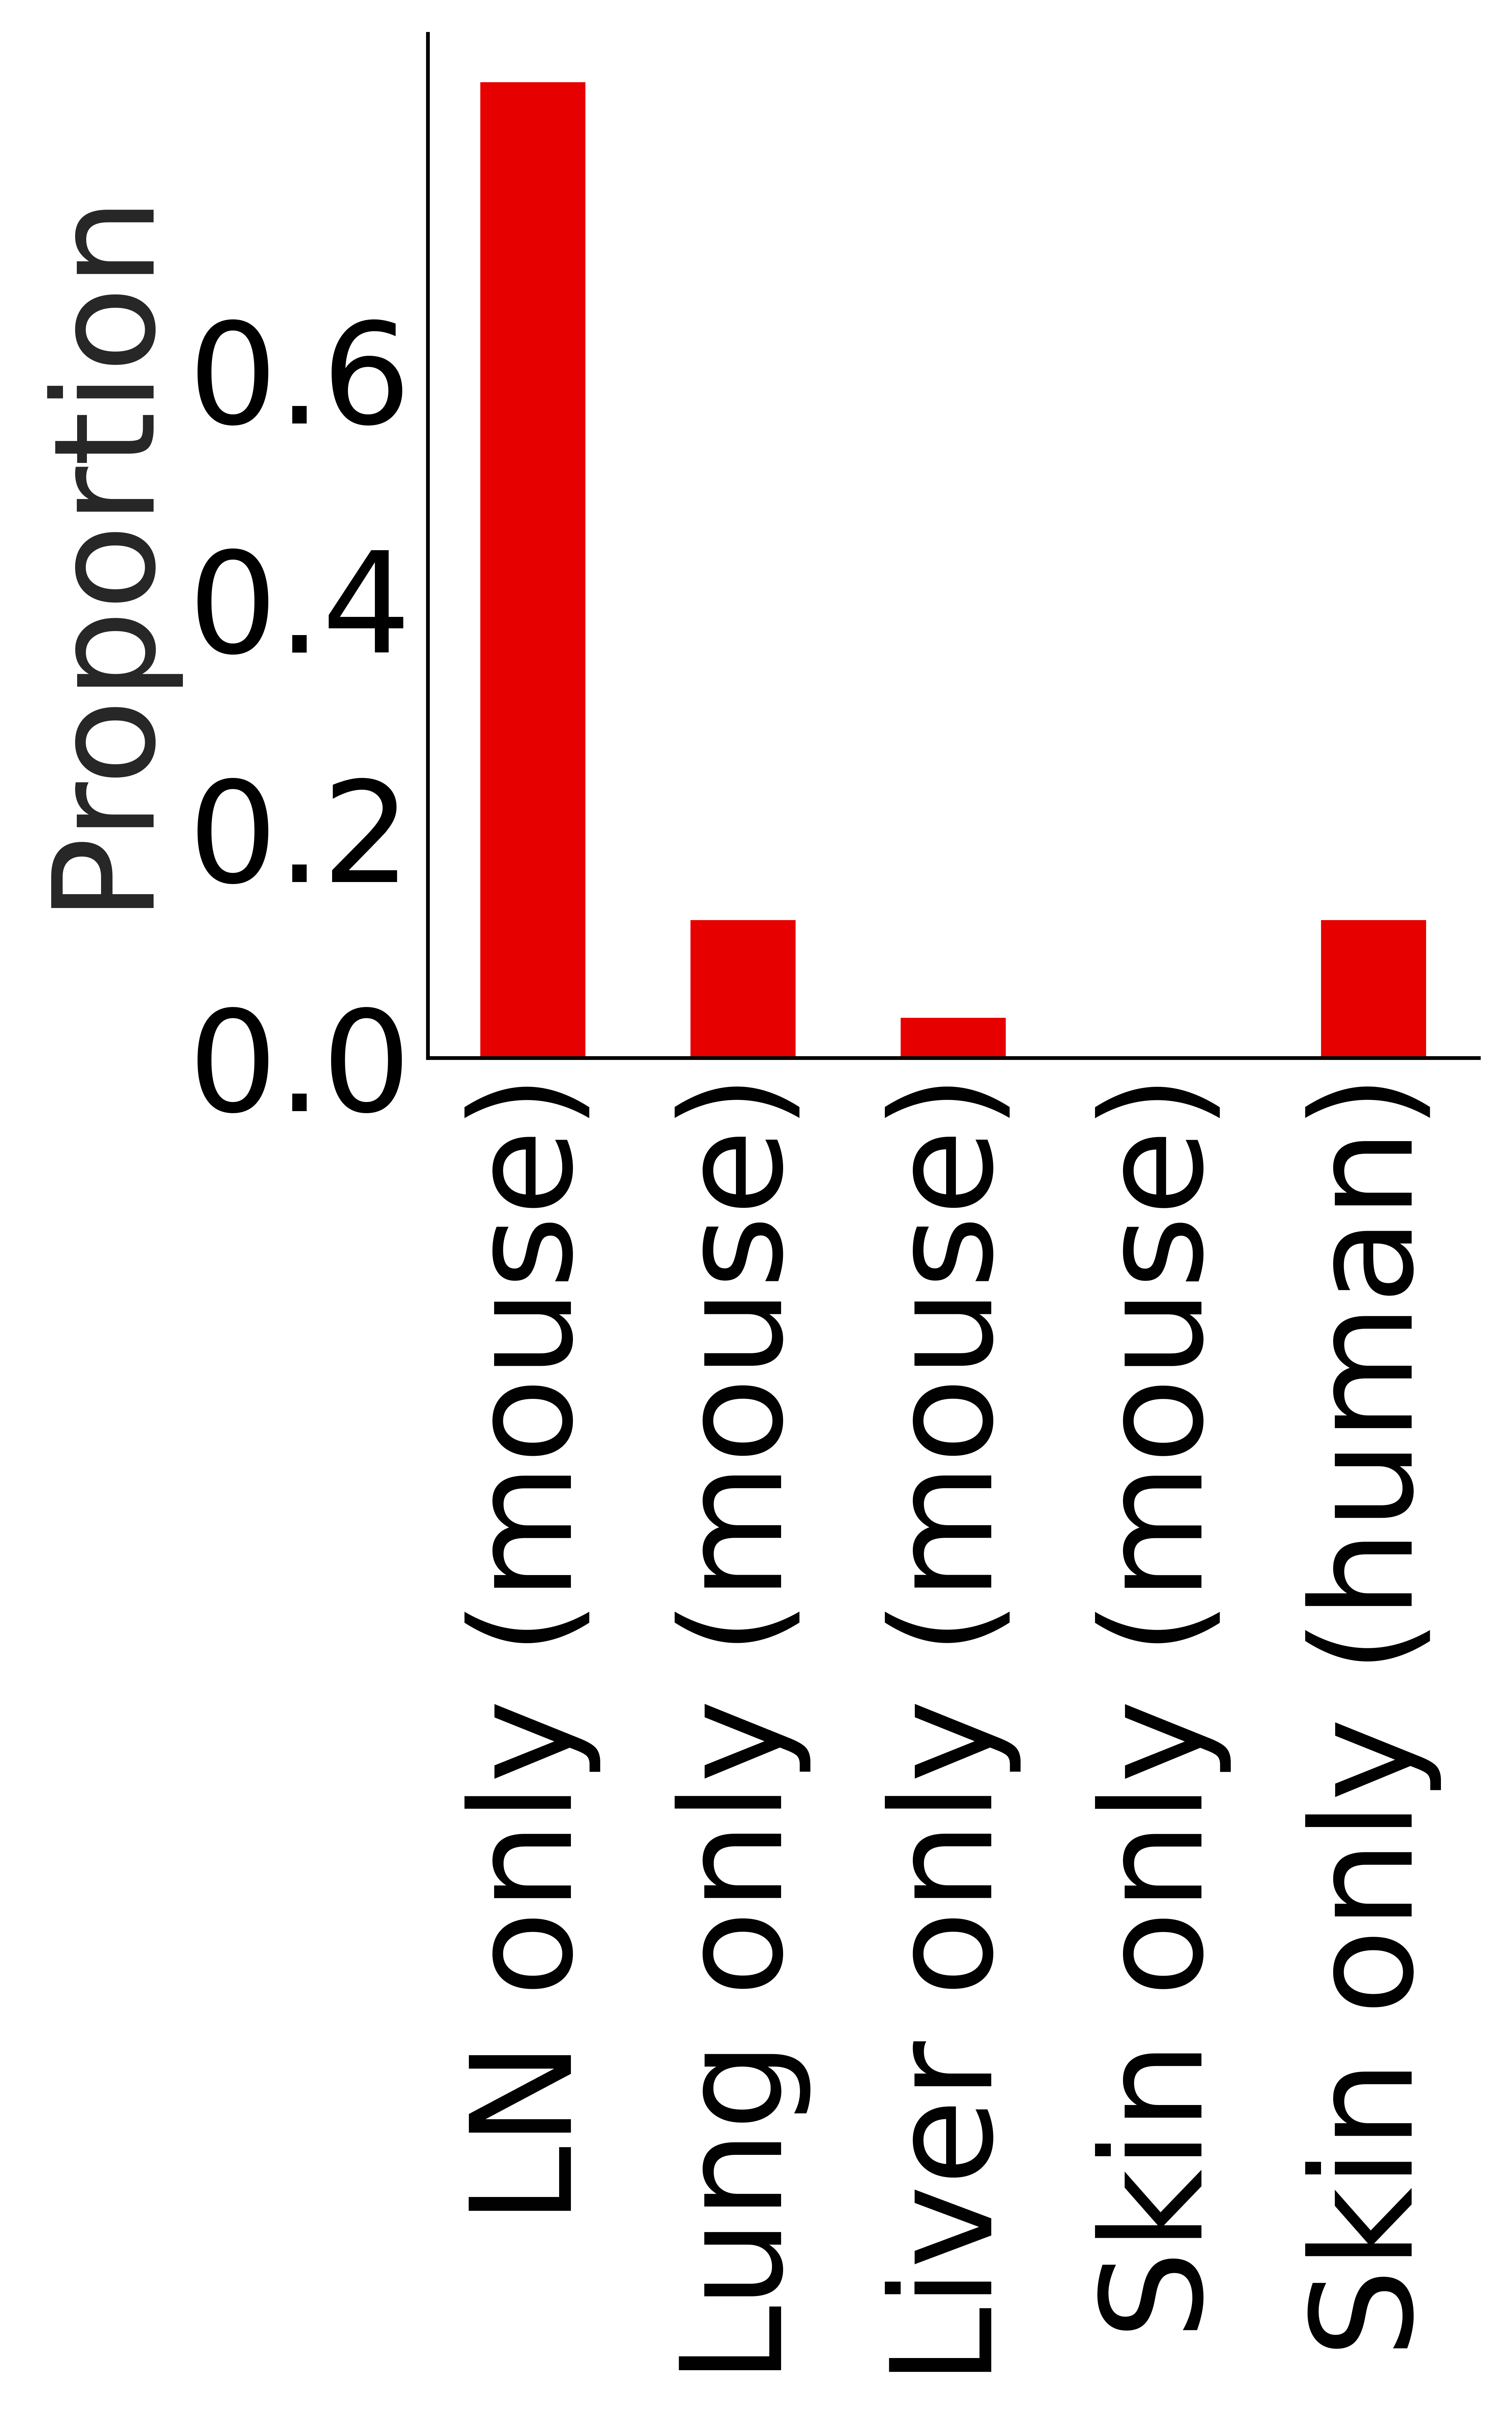

<Figure size 3500x3500 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=500, facecolor="white", frameon=False, figsize=(7,7))

 

# Round the Proportion values to avoid floating-point precision issues
df_grouped['Proportion'] = df_grouped['Proportion'].round(4)

# Pivot the data for easier plotting
df_pivot = df_grouped.pivot(index='Dataset', columns='ClustName', values='Proportion').fillna(0)

# Reorder the index to match the desired order
order = [ 'LN only (mouse)', 'Lung only (mouse)',  'Liver only (mouse)',  "Skin only (mouse)", "Skin only (human)"]
df_pivot = df_pivot.loc[order]

# Filter to only include the "Ccl19" column
df_pivot = df_pivot[['Ccl19']]

# Define custom color for the "Ccl19" with a redder color
color = '#e60000'  # Stronger red

# Plot the bar chart
ax = df_pivot.plot(kind='bar', stacked=True, color=color, figsize=(4, 4))

# Customize the plot
ax.set_xticklabels(ax.get_xticklabels(), fontsize=30, rotation=90)  # Make xticks font size bigger
ax.spines['top'].set_visible(False)  # Remove the top border
ax.spines['right'].set_visible(False)  # Remove the right border
ax.set_xlabel('')  # Remove the xlabel
ax.set_ylabel('Proportion', fontsize=30)  # Make ylabel font size bigger
ax.set_title('')  # Remove the title
#ax.set_ylim(0, 0.15)  # Set ymax to 0.2

# Fix yticks to have consistent spacing and display properly
ax.set_yticks([0.0, 0.2, 0.4, 0.6])
ax.set_yticklabels([f'{y:.1f}' for y in ax.get_yticks()], fontsize=30)  # Set yticks to 2 decimal places

# Remove the legend (since we only have one category)
ax.get_legend().remove()
# Remove the legend (since we only have one category)

# Remove the background grid
ax.grid(False)
# Display the plot
plt.show()
plt.savefig("fig6/mouse_ccl19.pdf")

 